In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from helpers.cm26 import DatasetCM26, read_datasets
from helpers.selectors import select_NA, select_Pacific, select_Cem, select_globe, compare, plot, select_ACC, select_Equator
from helpers.operators import Coarsen, Filtering, Subsampling, CoarsenKochkov, CoarsenWeighted, CoarsenKochkovMinMax
from helpers.state_functions import *

import hvplot.xarray
import hvplot
import cmocean

%load_ext autoreload
%autoreload 3

# Reading data on Greene

In [6]:
ds = read_datasets(['validate'], [4])['validate-4']

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-4


Text(0.5, 1.0, '0194-04-13 12:00:00, 3508.633056640625')

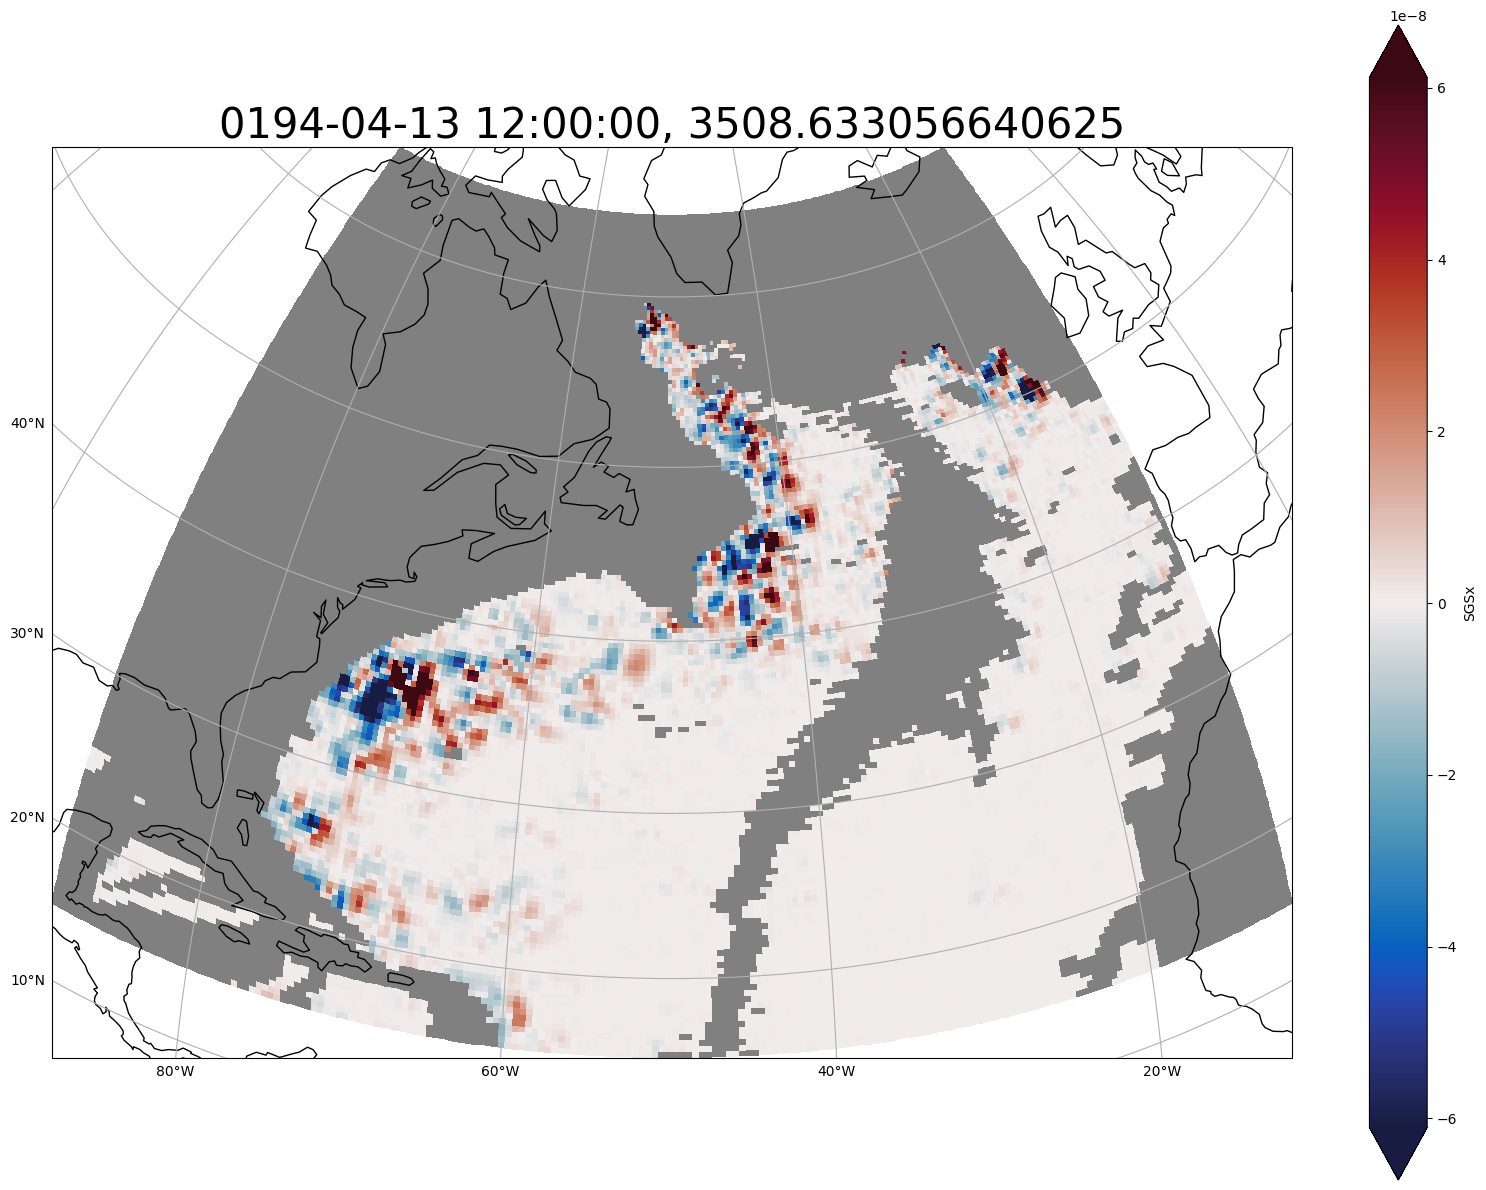

In [3]:
ds2d = ds.select2d(zl=8)
plot(ds2d.nanvar(ds2d.data.SGSx))
plt.title(f'{ds2d.data.time.values}, {ds2d.data.zl.values}', fontsize=30)

# Importance of relative vorticity approximation

Correlation: 0.9999624788225362
Relative Error: 0.009340805655077288
R2 =  0.9999248211250218
R2 max =  0.9999249644415138
Optinal scaling: 0.9996215574219995
Nans [test/control]: [17, 17]


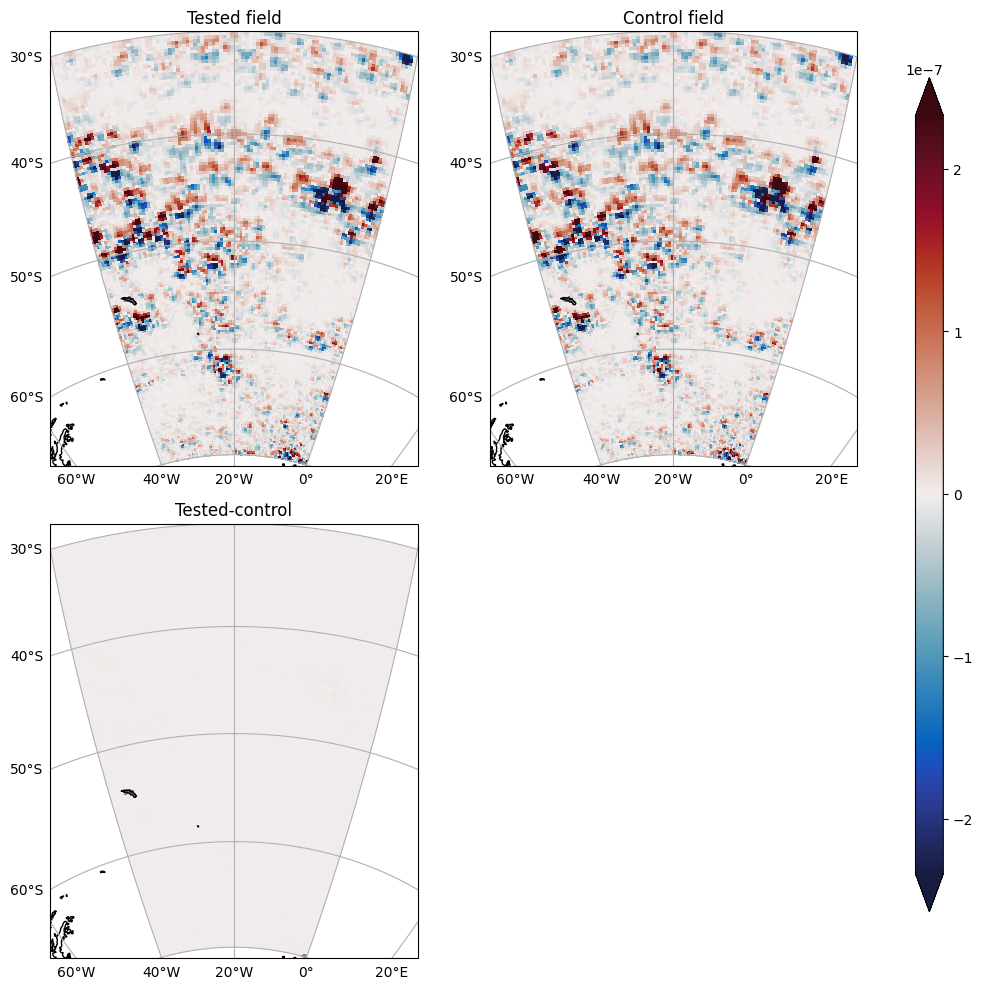

In [7]:
ds2d = ds.select2d(zl=0, time=0)
ann_Txy = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/surface/Gauss-FGR2/hdn-64-64-sym/model/Txy_epoch_2000.nc')
ann_Txx_Tyy = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/surface/Gauss-FGR2/hdn-64-64-sym/model/Txx_Tyy_epoch_2000.nc')
compare(ds2d.nanvar(ds2d.state.ANN(ann_Txy,ann_Txx_Tyy,gradient_features=['sh_xy', 'sh_xx', 'rel_vort'])['ZB20v']), 
        ds2d.nanvar(ds2d.state.ANN(ann_Txy,ann_Txx_Tyy,gradient_features=['sh_xy', 'sh_xx', 'vort_xy'])['ZB20v']), selector=select_ACC)

Correlation: 0.6934024225322433
Relative Error: 0.7286759613994569
R2 =  0.4614990367874712
R2 max =  0.48094988337620526
Optinal scaling: 0.8325678174491141
Nans [test/control]: [17666, 17666]


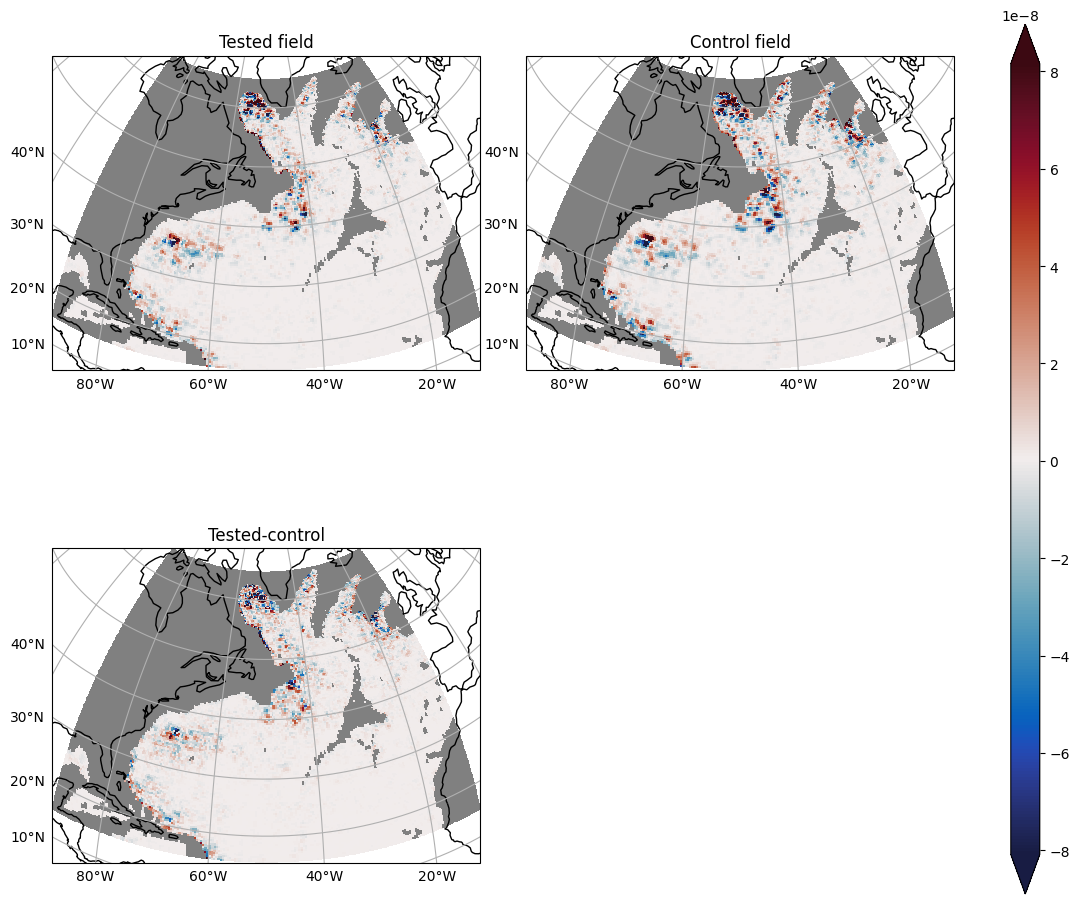

In [10]:
ds2d = ds.select2d(zl=7, time=0)
ann_Txy = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/surface/Gauss-FGR2/hdn-64-64-sym/model/Txy_epoch_2000.nc')
ann_Txx_Tyy = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/surface/Gauss-FGR2/hdn-64-64-sym/model/Txx_Tyy_epoch_2000.nc')
compare(ds2d.nanvar(ds2d.state.ANN(ann_Txy,ann_Txx_Tyy)['ZB20v']*1.35), ds2d.nanvar(ds2d.data.SGSy), selector=select_NA)

Correlation: 0.9237629313056089
Relative Error: 0.3429763240625278
R2 =  0.8460373556405116
R2 max =  0.853387087698757
Optinal scaling: 0.9150778890103493
Nans [test/control]: [20764, 20764]


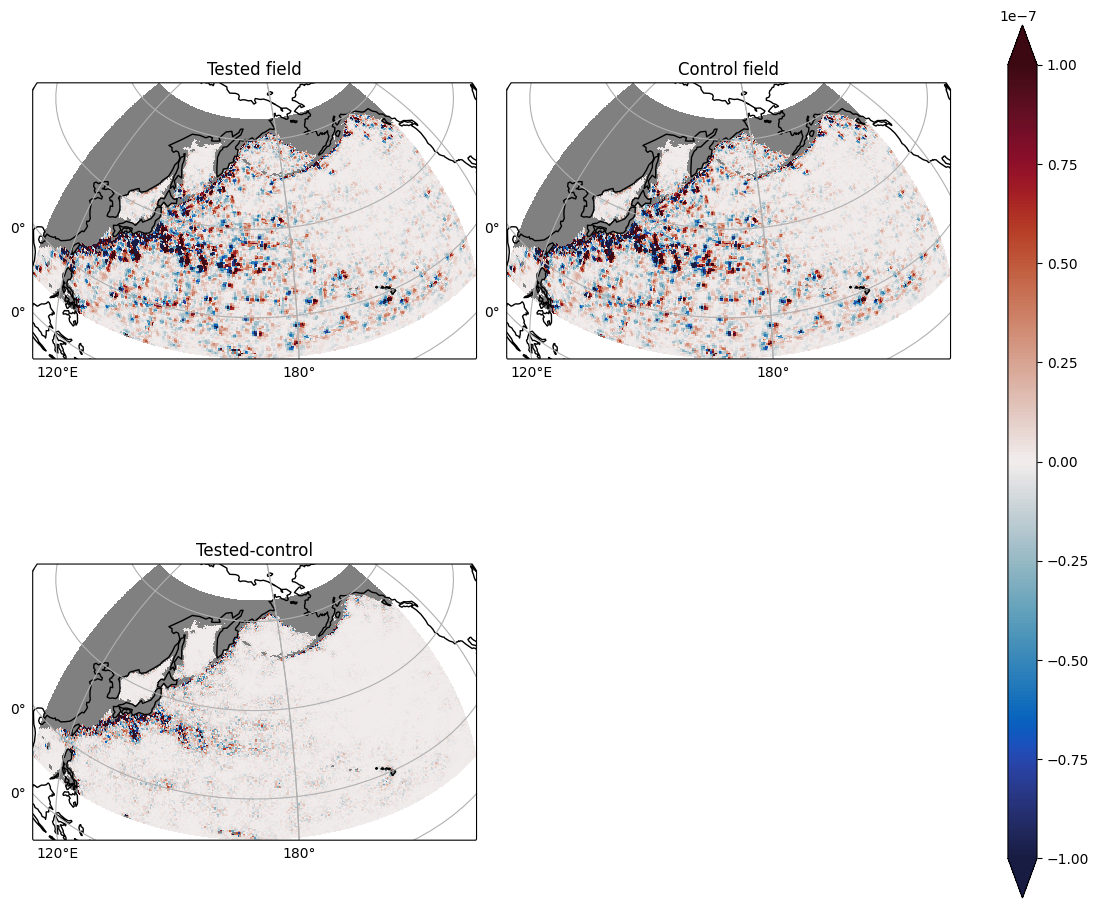

In [4]:
ds2d = ds.select2d(zl=3, time=0)
ann_Txy = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/hdn-64-64/model/Txy_epoch_2000.nc')
ann_Txx_Tyy = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/hdn-64-64/model/Txx_Tyy_epoch_2000.nc')
ann_Txy_sym = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/hdn-64-64-sym/model/Txy_epoch_2000.nc')
ann_Txx_Tyy_sym = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/hdn-64-64-sym/model/Txx_Tyy_epoch_2000.nc')
compare(ds2d.nanvar(ds2d.state.ANN(ann_Txy,ann_Txx_Tyy)['ZB20u']), ds2d.nanvar(ds2d.state.ANN(ann_Txy_sym,ann_Txx_Tyy_sym)['ZB20u']), 
        selector=select_Pacific, vmax = 10e-8, vmin=-10e-8)

# Normalization of input features

In [5]:
ds2d = ds.select2d(zl=0, time=0)
ann_Txy = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/hdn-64-64/model/Txy_epoch_2000.nc')
ann_Txx_Tyy = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/hdn-64-64/model/Txx_Tyy_epoch_2000.nc')
prediction = ds2d.state.ANN(ann_Txy,ann_Txx_Tyy)

In [16]:
for key in ['ZB20u', 'ZB20v', 'Txx', 'Txy', 'Tyy']:
    print(key, float(ds2d.nanvar(prediction[key]).std()))

ZB20u 8.919600664313859e-08
ZB20v 8.867400546762378e-08
Txx 0.005370180795959254
Txy 0.0028896510799977177
Tyy 0.006034607865284507


In [14]:
for key in ['sh_xx', 'sh_xy', 'vort_xy']:
    print(key, float(prediction[key].std()))

sh_xx 1.502939539932413e-06
sh_xy 1.3597741599369328e-06
vort_xy 1.9523954506439622e-06


In [15]:
(1e-6)**2 * (ds2d.param.dxT * ds2d.param.dyT).mean()

<xarray.DataArray ()>
array(0.00083459)
Coordinates:
    zl       float64 5.034

# Simple training script

In [3]:
from helpers.train_ann import train_ANN

In [16]:
ann_Txy, ann_Txx_Tyy, logger = train_ANN(time_iters=1000, print_iters=10)

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Factor: 12, depth: 0, MSE train/validate: [1.143903, 1.158397]
Factor: 15, depth: 0, MSE train/validate: [1.060304, 1.084349]
Iter/num_iters [10/1000]. Iter time/Remaining time in seconds: [0.56/591.4]
Factor: 12, depth: 0, MSE train/validate: [0.998607, 1.063141]
Factor: 15, depth: 0, MSE train/validate: [0.971053, 0.986936]
Iter/num_iters [20/1000]. Iter time/Remaining time in seconds: [0.56/568.8]
Factor: 12, depth: 0, MSE train/validate: [0.899062, 0.907822]
Factor: 15, depth: 0, MSE train/validate: [0.961181, 0.936922]
Iter/num_iters [30/1000]. Iter time/Remaining time in seconds: [0.56/556.4]
Factor: 12, depth: 0, MSE train/validate: [0.880290, 0.860

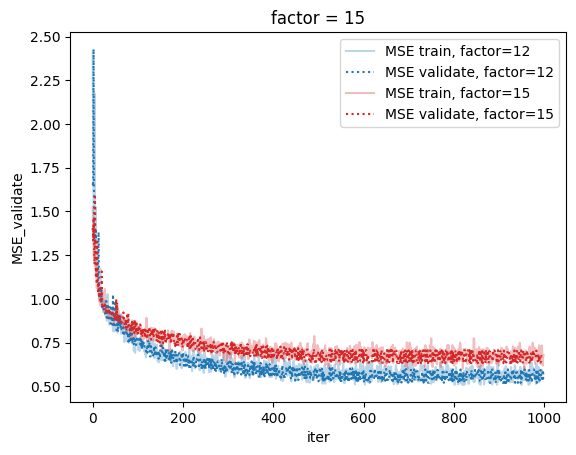

In [25]:
logger.MSE_train.sel(factor=12).plot(color='tab:blue', label='MSE train, factor=12', alpha=0.3)
logger.MSE_validate.sel(factor=12).plot(color='tab:blue', ls=':', label='MSE validate, factor=12')

logger.MSE_train.sel(factor=15).plot(color='tab:red', label='MSE train, factor=15', alpha=0.3)
logger.MSE_validate.sel(factor=15).plot(color='tab:red', ls=':', label='MSE validate, factor=15')
plt.legend()

In [26]:
ds = read_datasets(['test'], [12])['test-12']

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12


Correlation: 0.5913286266150832
Relative Error: 0.8170916348817914
R2 =  0.34908953634344553
R2 max =  0.3498534335899428
Optinal scaling: 1.049018208730356
Nans [test/control]: [948, 948]


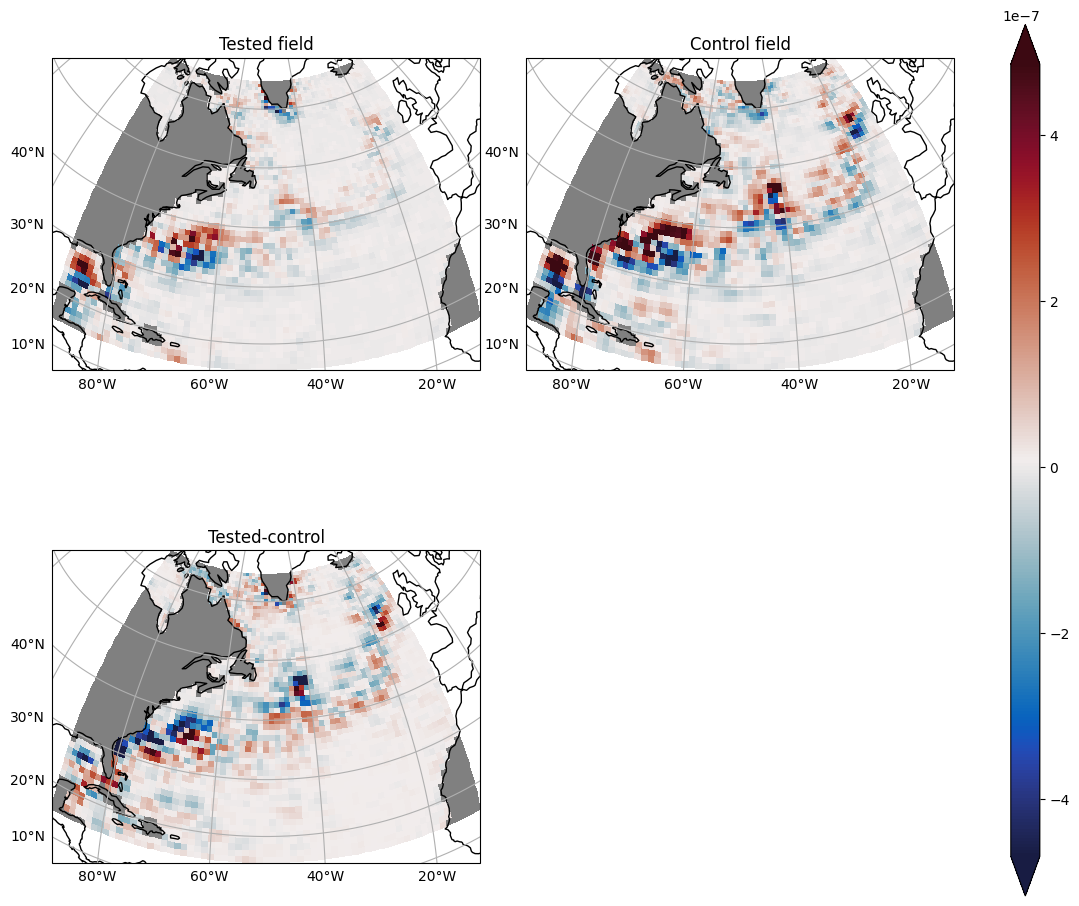

In [28]:
ds2d = ds.select2d(zl=0)
compare(ds2d.nanvar(ds2d.state.ANN(ann_Txy,ann_Txx_Tyy)['ZB20v']), ds2d.nanvar(ds2d.data.SGSy), selector=select_NA)

# Off dimensional scaling

In [17]:
from helpers.train_ann import train_ANN

In [35]:
ann_Txy, ann_Txx_Tyy, logger = train_ANN(time_iters=1000, print_iters=50, dimensional_scaling=False)

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Factor: 12, depth: 0, MSE train/validate: [0.975675, 0.978889]
Factor: 15, depth: 0, MSE train/validate: [0.987283, 0.987101]
Iter/num_iters [50/1000]. Iter time/Remaining time in seconds: [0.96/660.1]
Factor: 12, depth: 0, MSE train/validate: [0.950152, 0.940990]
Factor: 15, depth: 0, MSE train/validate: [0.965926, 0.963087]
Iter/num_iters [100/1000]. Iter time/Remaining time in seconds: [0.63/673.5]
Factor: 12, depth: 0, MSE train/validate: [0.901856, 0.902869]
Factor: 15, depth: 0, MSE train/validate: [0.935096, 0.939790]
Iter/num_iters [150/1000]. Iter time/Remaining time in seconds: [0.66/643.9]
Factor: 12, depth: 0, MSE train/validate: [0.861953, 0.8

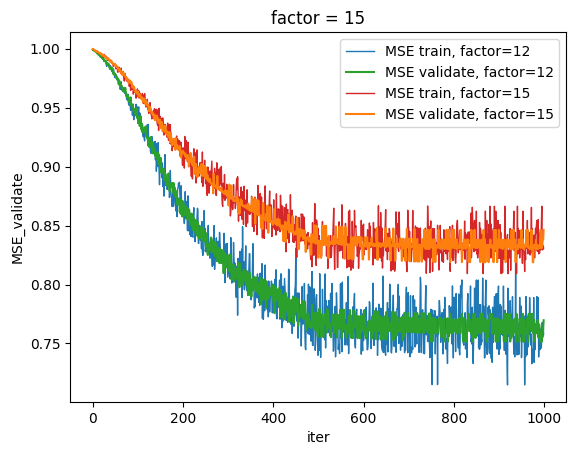

In [40]:
logger.MSE_train.sel(factor=12,depth=0).plot(color='tab:blue', label='MSE train, factor=12', alpha=1, lw=1)
logger.MSE_validate.sel(factor=12,depth=0).plot(color='tab:green', ls='-', label='MSE validate, factor=12')

logger.MSE_train.sel(factor=15,depth=0).plot(color='tab:red', label='MSE train, factor=15', lw=1)
logger.MSE_validate.sel(factor=15,depth=0).plot(color='tab:orange', ls='-', label='MSE validate, factor=15')


plt.legend()

In [41]:
ds = read_datasets(['test'], [12])['test-12']

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12


Correlation: 0.5193204015963081
Relative Error: 0.9198297601742009
R2 =  0.25991329807243946
R2 max =  0.27267627131187866
Optinal scaling: 1.2760760853251762
Nans [test/control]: [948, 948]


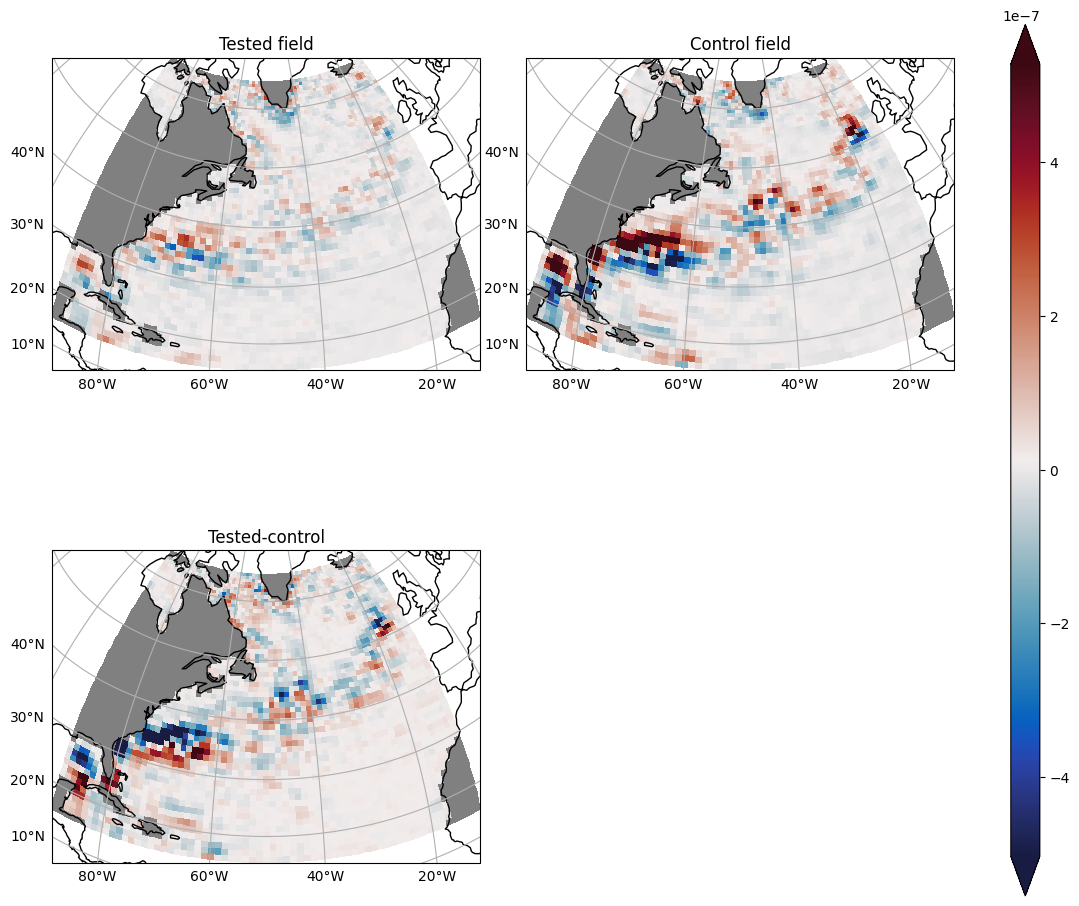

In [48]:
ds2d = ds.select2d(zl=0)
compare(ds2d.nanvar(ds2d.state.ANN(ann_Txy,ann_Txx_Tyy,dimensional_scaling=False)['ZB20v']), ds2d.nanvar(ds2d.data.SGSy), selector=select_NA)

# Passing additional features

In [3]:
from helpers.feature_extractors import *

In [4]:
ds = read_datasets(['test'], [4,15])

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-4
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15


In [7]:
ds4 = ds['test-4'].select2d(zl=0)
ds15 = ds['test-15'].select2d(zl=0)

In [8]:
def plot_hist(function):
    plt.figure(figsize=(12,10))
    plt.subplot(2,2,1)
    plt.hist(ds4.nanvar(function(ds4)[0]).values.ravel(),100);
    plt.subplot(2,2,2)
    plt.hist(ds4.nanvar(function(ds4)[1]).values.ravel(),100);
    plt.subplot(2,2,3)
    plt.hist(ds15.nanvar(function(ds15)[1]).values.ravel(),100);
    plt.subplot(2,2,4)
    plt.hist(ds15.nanvar(function(ds15)[1]).values.ravel(),100);

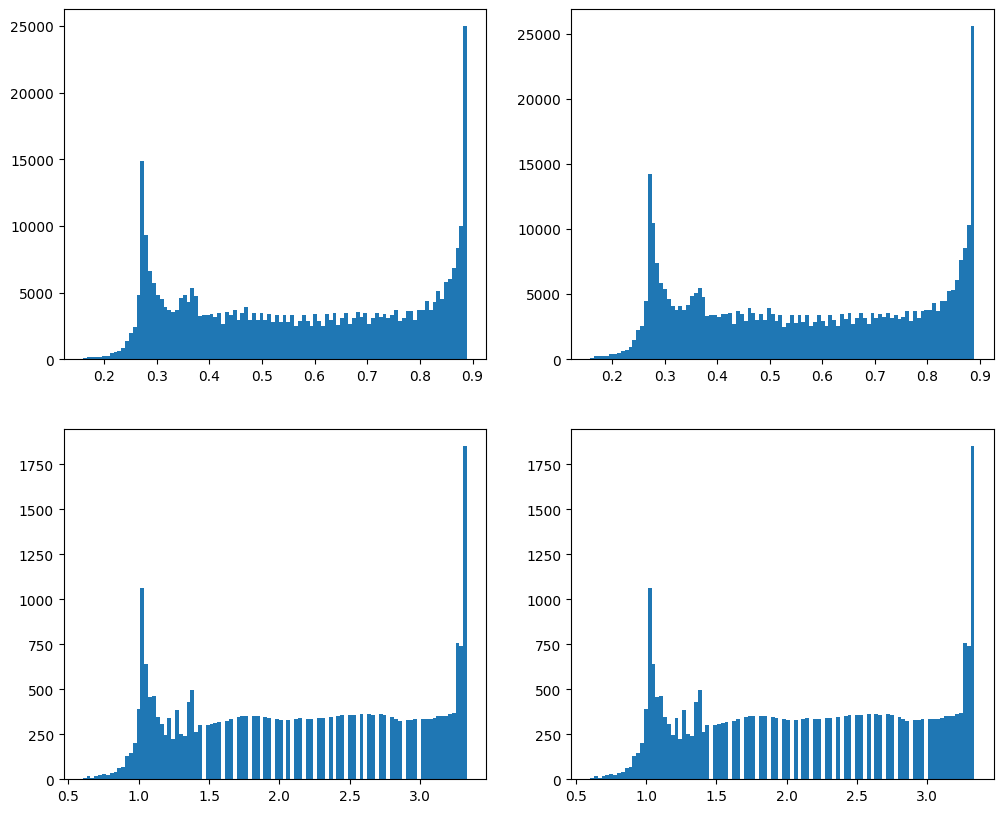

In [9]:
plot_hist(grid_step)

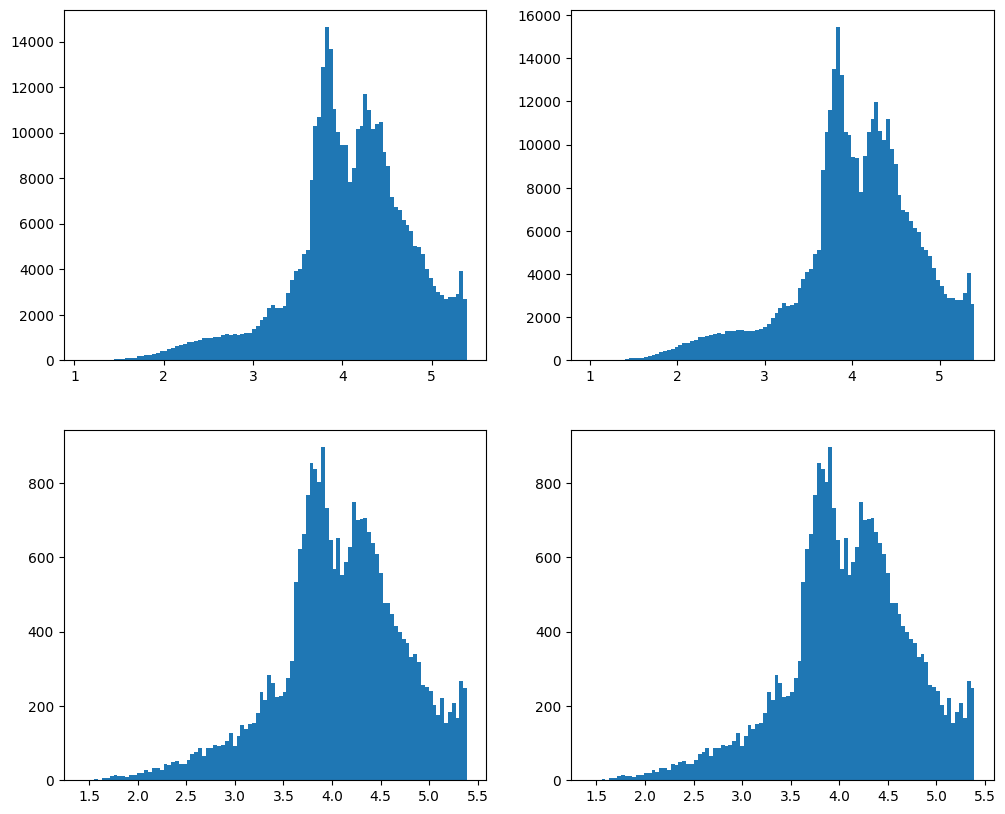

In [10]:
plot_hist(deformation_radius)

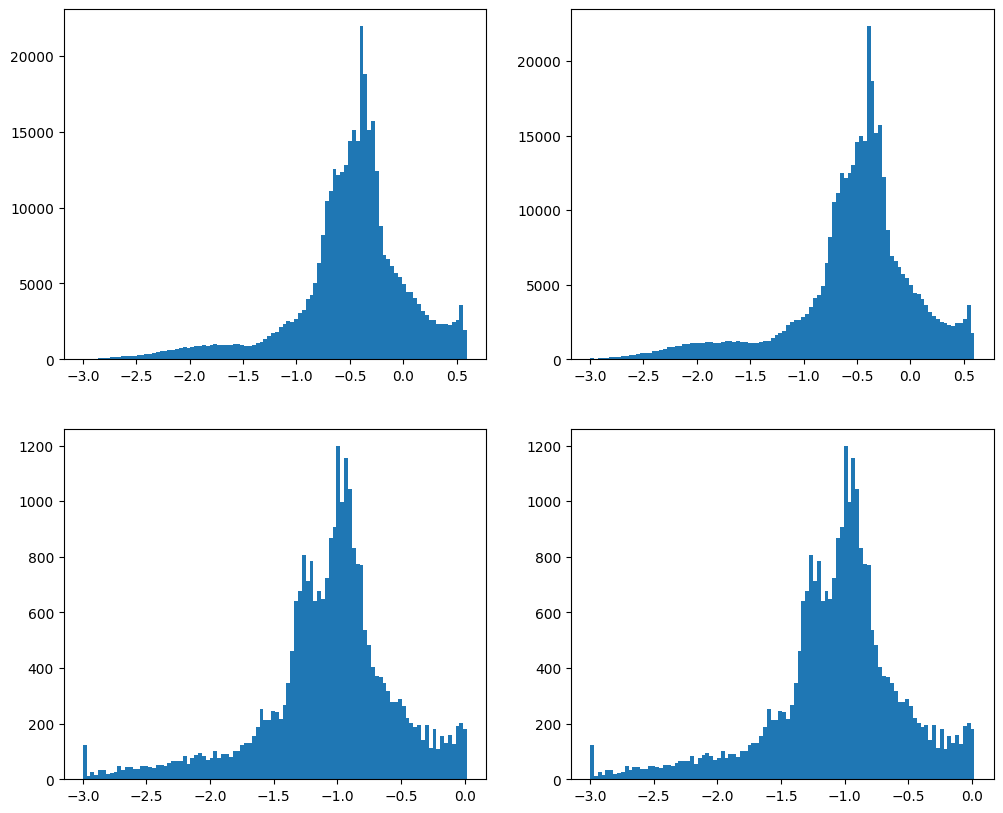

In [11]:
plot_hist(deformation_radius_over_grid_spacing)

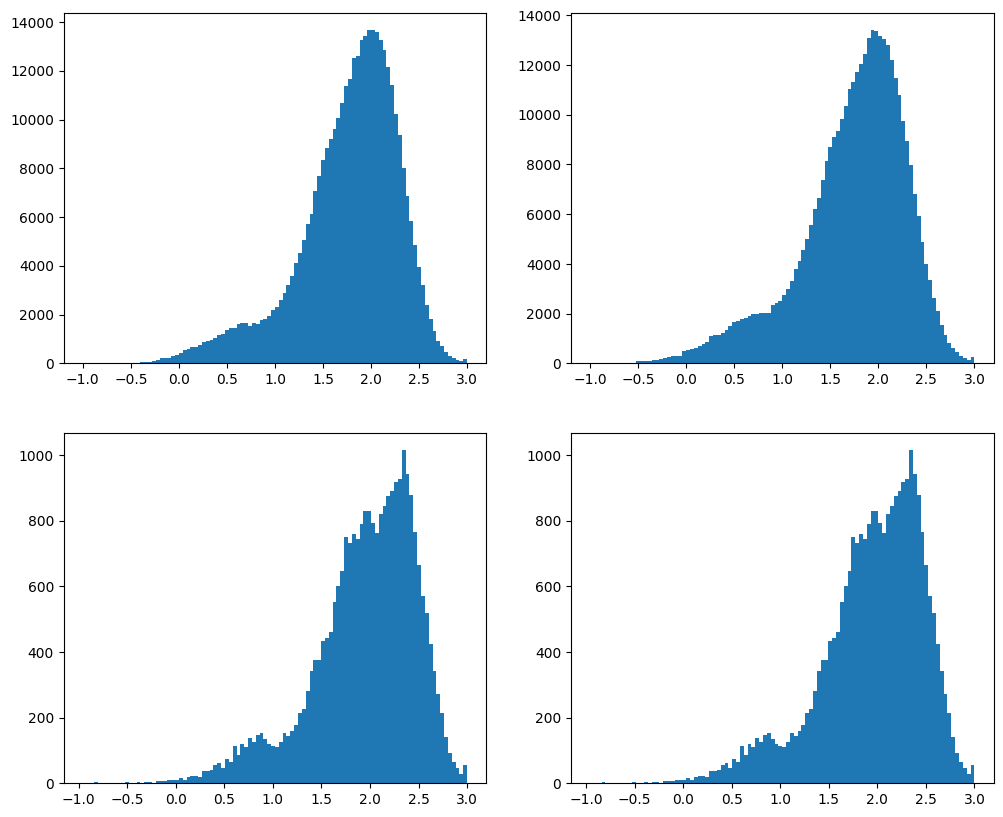

In [12]:
plot_hist(square_root_of_Ri)

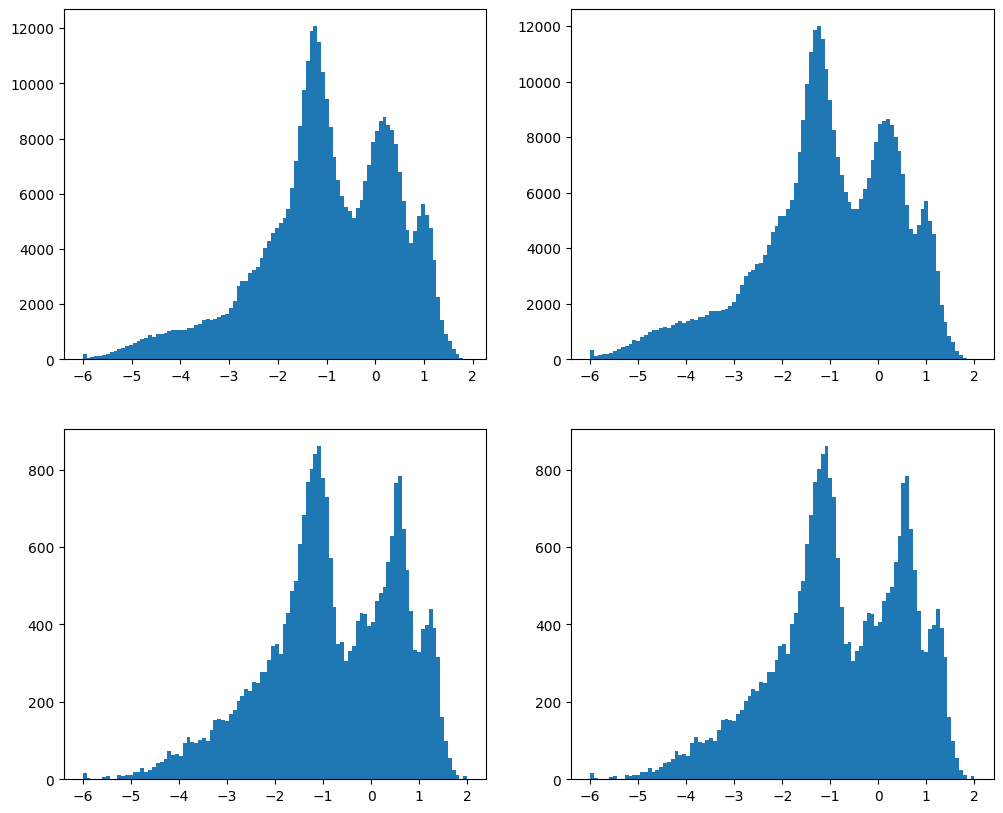

In [13]:
plot_hist(Held_Larichev_1996)

In [14]:
ds4 = ds['test-4'].select2d(zl=5)
ds15 = ds['test-15'].select2d(zl=5)

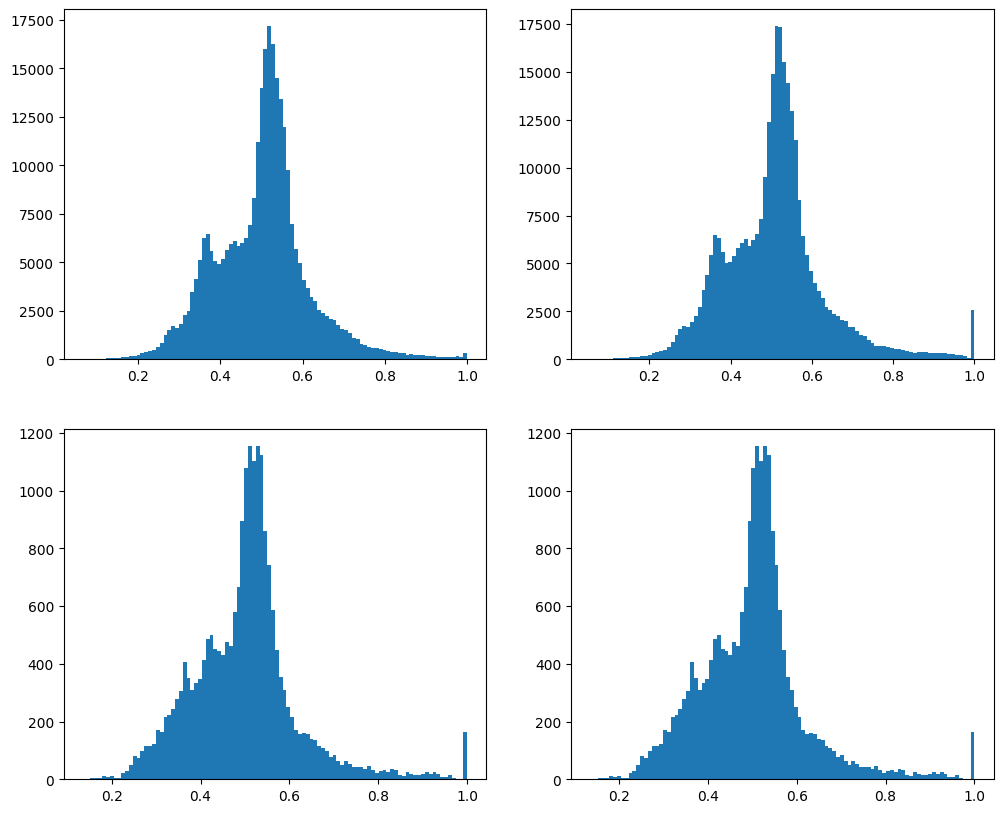

In [15]:
plot_hist(rescaled_depth)

# Training with additional features

In [21]:
from helpers.feature_extractors import *
from helpers.train_ann import train_ANN

In [30]:
ann_Txy, ann_Txx_Tyy, logger = train_ANN(time_iters=30, print_iters=5, depth_idx=np.arange(10), feature_functions=[deformation_radius_over_grid_spacing, Held_Larichev_1996, square_root_of_Ri, rescaled_depth])

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Factor: 12, depth: 0, MSE train/validate: [1.086825, 1.004835]
Factor: 12, depth: 1, MSE train/validate: [1.010257, 0.959118]
Factor: 12, depth: 2, MSE train/validate: [1.028119, 0.999220]
Factor: 12, depth: 3, MSE train/validate: [0.965996, 0.964838]
Factor: 12, depth: 4, MSE train/validate: [0.964863, 0.891478]
Factor: 12, depth: 5, MSE train/validate: [0.929345, 0.920575]
Factor: 12, depth: 6, MSE train/validate: [0.836974, 0.964933]
Factor: 12, depth: 7, MSE train/validate: [0.863351, 0.933423]
Factor: 12, depth: 8, MSE train/validate: [0.882829, 0.906705]
Factor: 12, depth: 9, MSE train/validate: [0.837780, 0.975383]
Factor: 15, depth: 0, MSE train/va

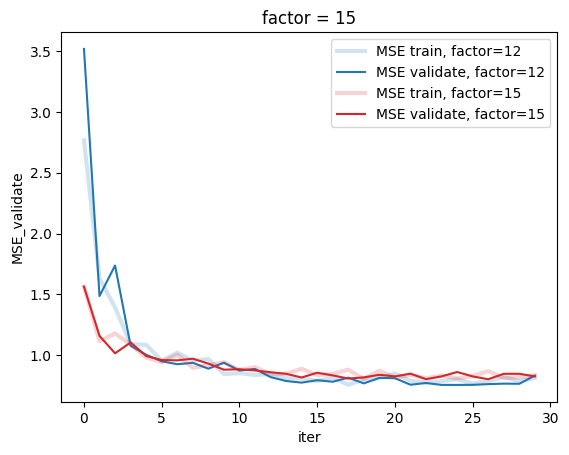

In [33]:
logger.MSE_train.sel(factor=12,depth=0).plot(color='tab:blue', label='MSE train, factor=12',lw=3, alpha=0.2)
logger.MSE_validate.sel(factor=12,depth=0).plot(color='tab:blue', ls='-', label='MSE validate, factor=12')

logger.MSE_train.sel(factor=15,depth=0).plot(color='tab:red', label='MSE train, factor=15', lw=3, alpha=0.2)
logger.MSE_validate.sel(factor=15,depth=0).plot(color='tab:red', ls='-', label='MSE validate, factor=15')

plt.legend()

In [34]:
ds = read_datasets(['test'], [12])['test-12']

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12


Correlation: 0.44080238099109686
Relative Error: 0.9152697862144344
R2 =  0.16410212999613716
R2 max =  0.19442469890391
Optinal scaling: 1.6526695874612356
Nans [test/control]: [1994, 1994]


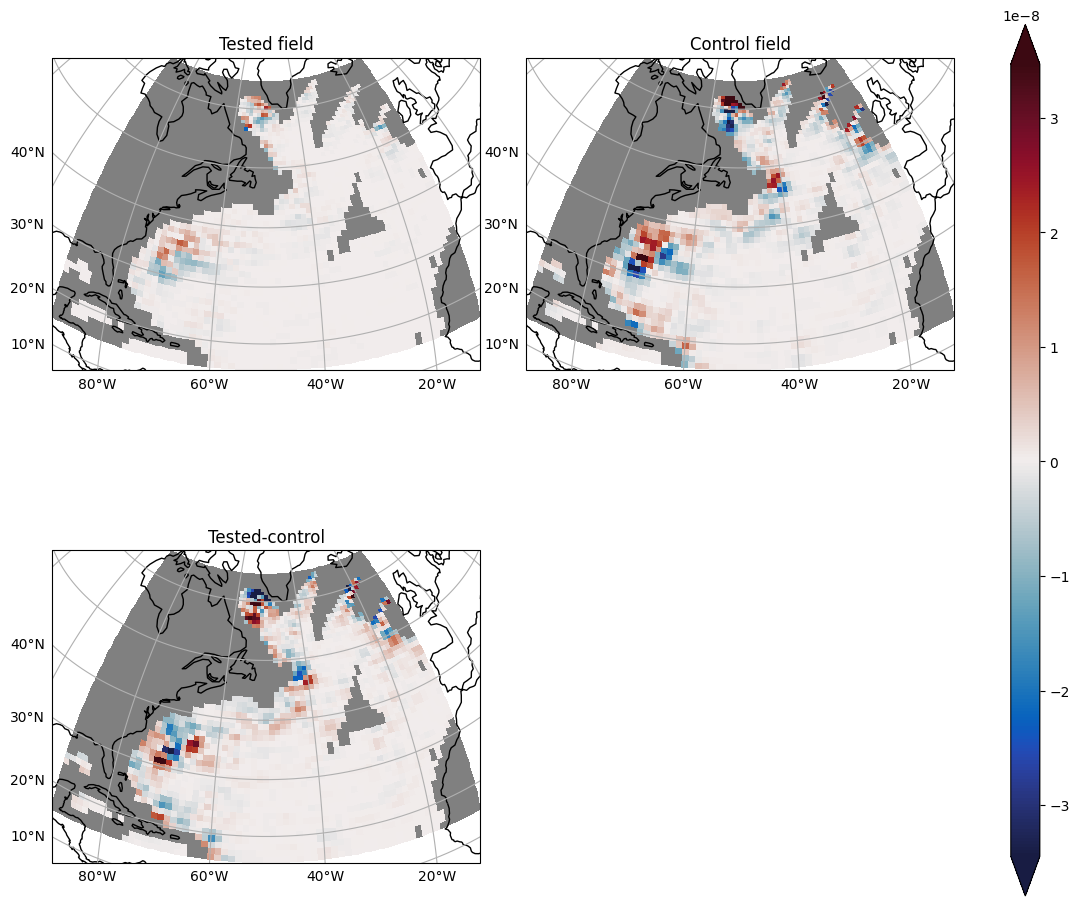

In [38]:
ds2d = ds.select2d(zl=7)
compare(ds2d.nanvar(ds2d.state.ANN(ann_Txy,ann_Txx_Tyy,
                                  feature_functions=[deformation_radius_over_grid_spacing, Held_Larichev_1996, square_root_of_Ri, rescaled_depth])['ZB20v']), ds2d.nanvar(ds2d.data.SGSy), selector=select_NA)

# Check trained models

In [44]:
import os

{"factors": "[4,9,12,15]", "stencil_size": 3, "hidden_layers": "[64,64]", "dimensional_scaling": "True", "symmetries": "True", "time_iters": 200, "depth_idx": "np.arange(10)", "print_iters": 10, "feature_functions": "[deformation_radius_over_grid_spacing, Held_Larichev_1996, square_root_of_Ri, rescaled_depth]", "path_save": "/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/EXP0"}

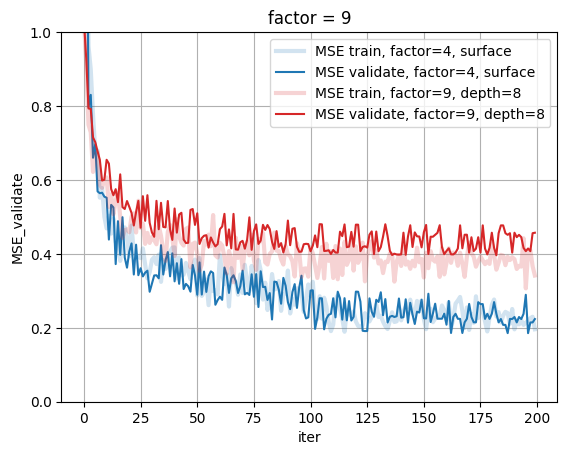

In [62]:
logger = xr.open_dataset('/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/EXP0/model/logger.nc')
os.system('cat /scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/EXP0/configuration.txt')

logger.MSE_train.sel(factor=4,depth=0).plot(color='tab:blue', label='MSE train, factor=4, surface',lw=3, alpha=0.2)
logger.MSE_validate.sel(factor=4,depth=0).plot(color='tab:blue', ls='-', label='MSE validate, factor=4, surface')

depth = 8
factor = 9
logger.MSE_train.sel(factor=factor,depth=depth).plot(color='tab:red', label=f'MSE train, factor={factor}, depth={depth}', lw=3, alpha=0.2)
logger.MSE_validate.sel(factor=factor,depth=depth).plot(color='tab:red', ls='-', label=f'MSE validate, factor={factor}, depth={depth}')

plt.legend()
plt.ylim([0,1])
plt.grid()

{"factors": "[9]", "stencil_size": 3, "hidden_layers": "[64,64]", "dimensional_scaling": "False", "symmetries": "True", "time_iters": 8000, "depth_idx": "[0]", "print_iters": 10, "feature_functions": "[]", "path_save": "/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/EXP4"}

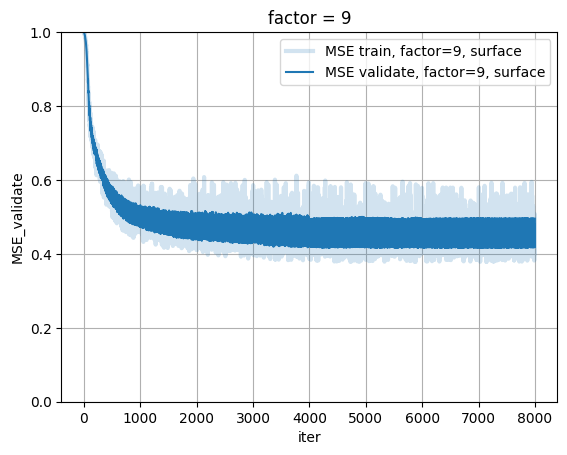

In [60]:
logger = xr.open_dataset('/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/EXP4/model/logger.nc')
os.system('cat /scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/EXP4/configuration.txt')

logger.MSE_train.sel(factor=9,depth=0).plot(color='tab:blue', label='MSE train, factor=9, surface',lw=3, alpha=0.2)
logger.MSE_validate.sel(factor=9,depth=0).plot(color='tab:blue', ls='-', label='MSE validate, factor=9, surface')

# depth = 8
# factor = 9
# logger.MSE_train.sel(factor=factor,depth=depth).plot(color='tab:red', label=f'MSE train, factor={factor}, depth={depth}', lw=3, alpha=0.2)
# logger.MSE_validate.sel(factor=factor,depth=depth).plot(color='tab:red', ls='-', label=f'MSE validate, factor={factor}, depth={depth}')

plt.legend()
plt.ylim([0,1])
plt.grid()

# Trained model on testing dataset

In [274]:
from helpers.feature_extractors import *
import json

In [275]:
def read_ANN(exp='EXP0'):
    ann_Txy = import_ANN(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/{exp}/model/Txy.nc')
    ann_Txx_Tyy = import_ANN(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/{exp}/model/Txx_Tyy.nc')
    with open(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/{exp}/configuration.txt') as f:
        config = json.load(f)
    # Dictionary with additional arguments required for inference
    kw = {}
    kw['stencil_size'] = config['stencil_size']
    kw['dimensional_scaling'] = eval(config['dimensional_scaling'])
    kw['feature_functions'] = eval(config['feature_functions'])

    print(config)
    return ann_Txy, ann_Txx_Tyy, kw

In [83]:
ds = read_datasets(['test'], [4,9,12,15])

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-4
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-9
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15


{'factors': '[4,9,12,15]', 'stencil_size': 3, 'hidden_layers': '[64,64]', 'dimensional_scaling': 'True', 'symmetries': 'True', 'time_iters': 200, 'depth_idx': 'np.arange(10)', 'print_iters': 10, 'feature_functions': '[deformation_radius_over_grid_spacing, Held_Larichev_1996, square_root_of_Ri, rescaled_depth]', 'path_save': '/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/EXP0'}
Correlation: 0.7481949841769958
Relative Error: 0.7546548128354593
R2 =  0.5451506960827618
R2 max =  0.5600059822822158
Optinal scaling: 1.1945592576652595
Nans [test/control]: [22171, 22171]


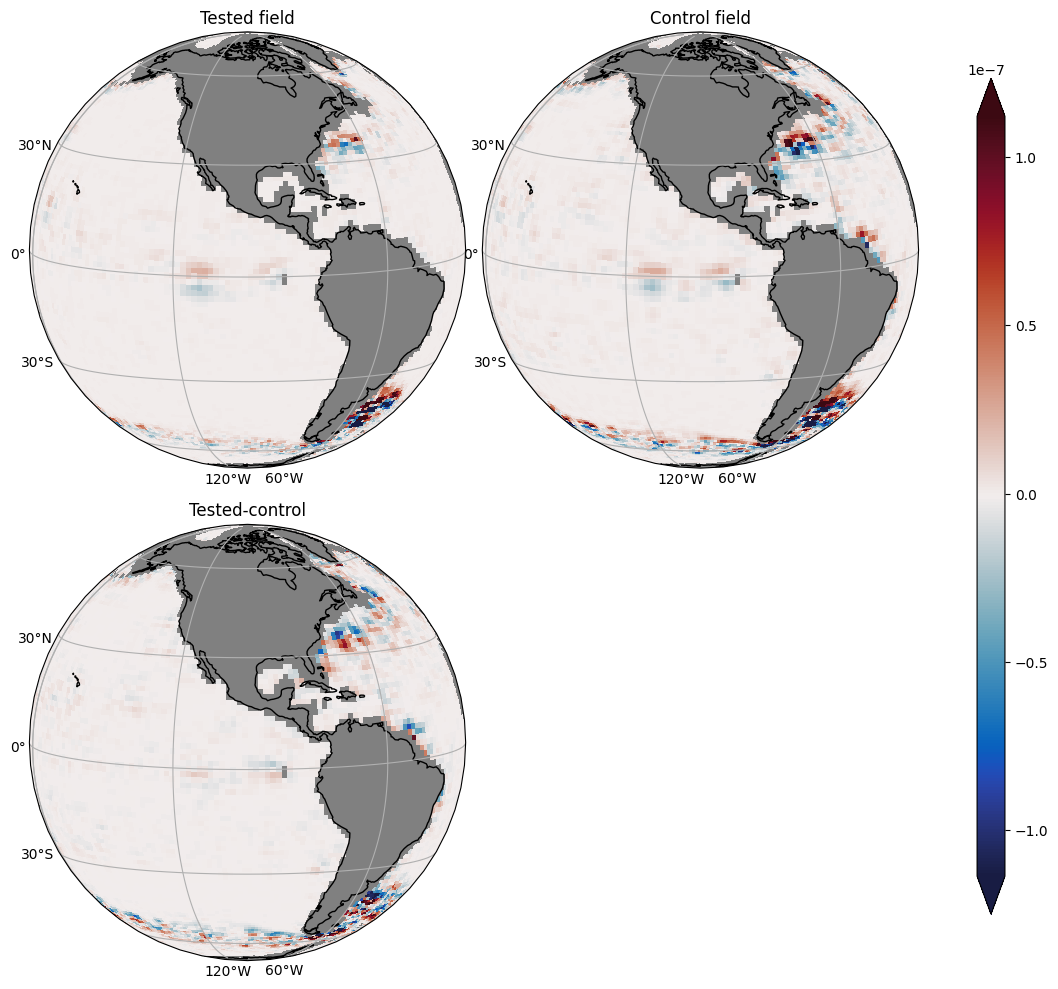

In [147]:
ann_Txy, ann_Txx_Tyy, kw = read_ANN('EXP0')
ds2d = ds['test-15'].select2d(zl=5,time=23)
compare(ds2d.nanvar(ds2d.state.ANN(ann_Txy,ann_Txx_Tyy,**kw)['ZB20v']), ds2d.nanvar(ds2d.data.SGSy), selector=select_globe)

In [229]:
ann_Txy, ann_Txx_Tyy, kw = read_ANN('EXP2')
%time dataset = ds['test-9'].predict_ANN(ann_Txy, ann_Txx_Tyy, **kw)

{'factors': '[4,9,12,15]', 'stencil_size': 3, 'hidden_layers': '[64,64]', 'dimensional_scaling': 'True', 'symmetries': 'True', 'time_iters': 2000, 'depth_idx': '[0]', 'print_iters': 10, 'feature_functions': '[]', 'path_save': '/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/EXP2'}
CPU times: user 1min 58s, sys: 28.3 s, total: 2min 26s
Wall time: 48.6 s


Correlation: 0.6388963073470068
Relative Error: 0.7438401579856873
R2 =  0.39767831563949585
R2 max =  0.4071351885795593
Optinal scaling: 0.8677491545677185
Nans [test/control]: [0, 0]


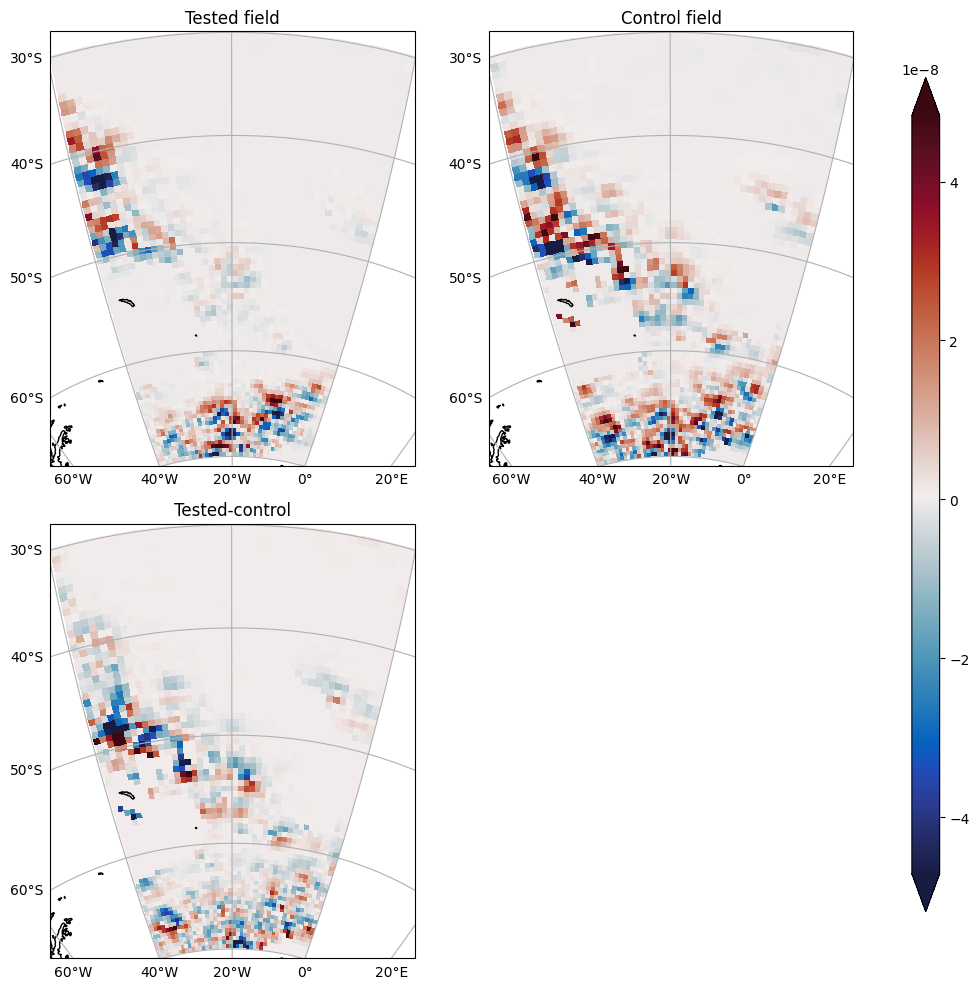

In [205]:
compare(dataset.data.ZB20v.isel(zl=8),dataset.data.SGSy.isel(zl=8), selector=select_ACC)

In [278]:
%time dataset = ds['test-9'].predict_ANN(ann_Txy, ann_Txx_Tyy, **kw)
%time SGS_skill = dataset.SGS_skill()

CPU times: user 2min 4s, sys: 12.9 s, total: 2min 17s
Wall time: 47.8 s
CPU times: user 1min 44s, sys: 2min 12s, total: 3min 56s
Wall time: 1min 18s


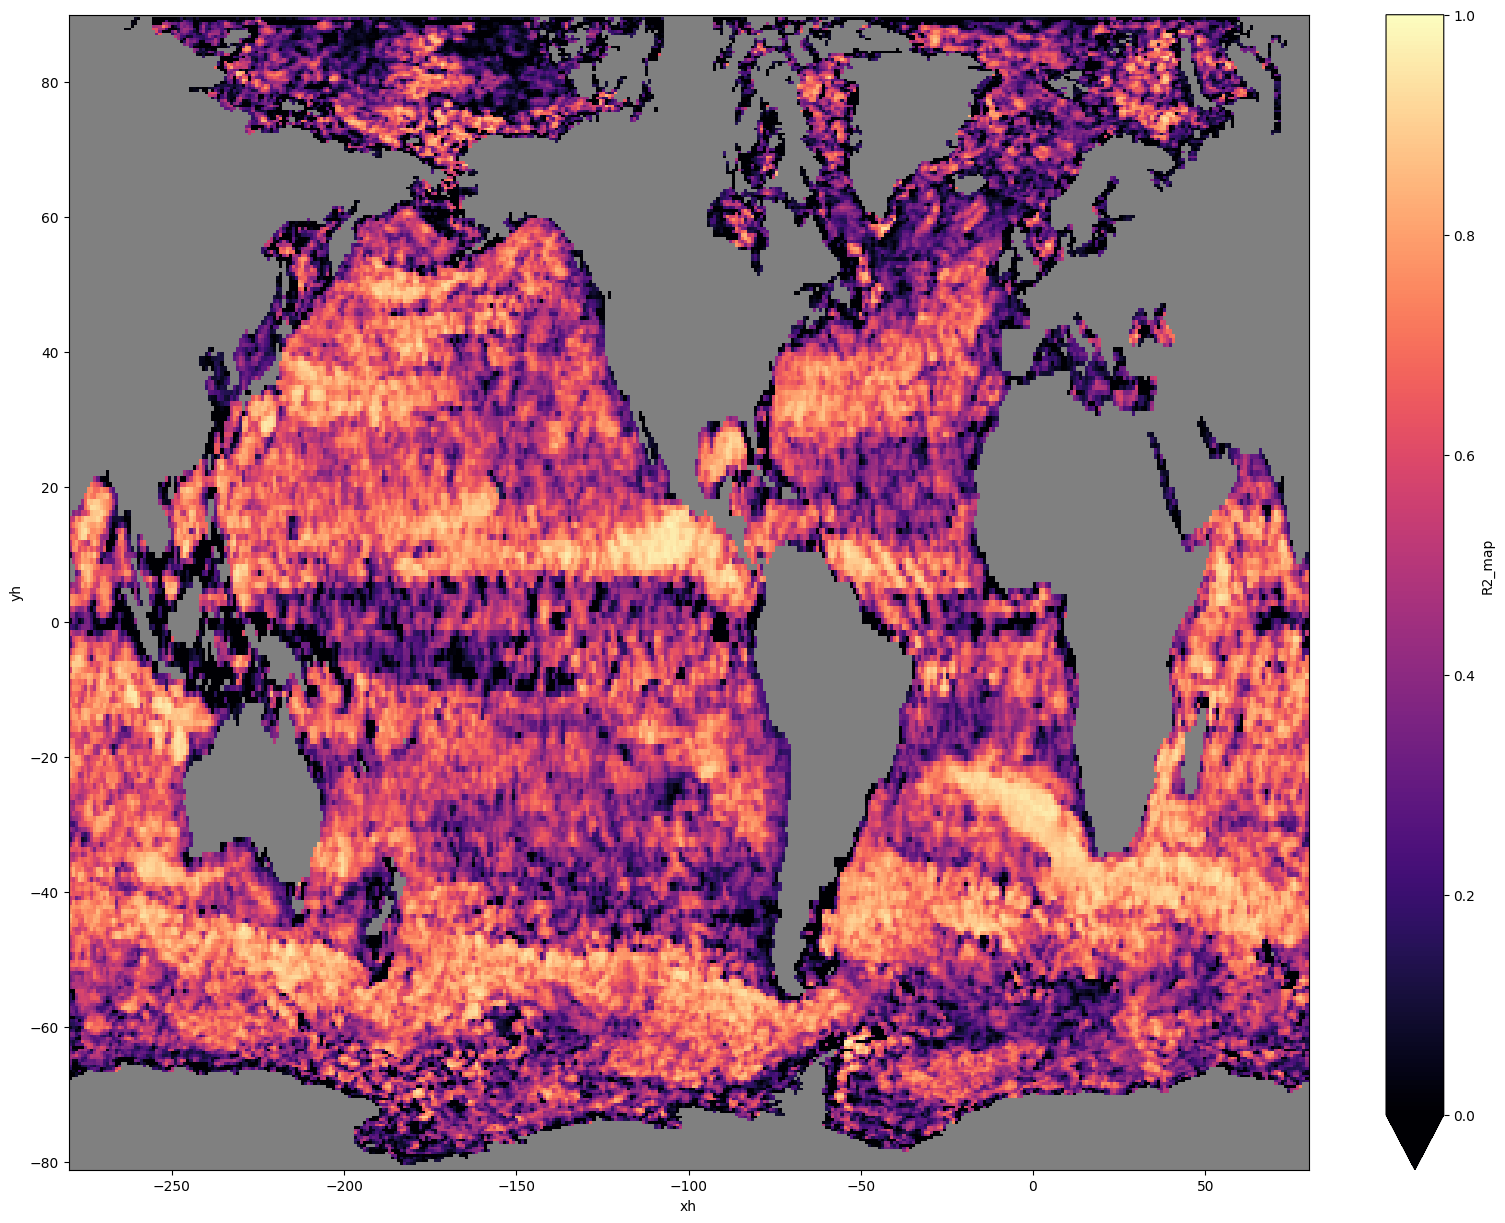

In [250]:
import matplotlib as mpl
import cmocean
plt.figure(figsize=(20,15))
plot(SGS_skill.R2_map[0], vmin=0, vmax=1, selector=select_globe, cartopy=False, cmap=mpl.cm.magma)

# Computing skill for all models on all datasets

In [280]:
import os

In [279]:
ds = read_datasets(['test'], [4,9,12,15])

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-4
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-9
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15


In [282]:
for exp in [f'EXP{exp_num}' for exp_num in range(10)]:
    ann_Txy, ann_Txx_Tyy, kw = read_ANN(exp)
    os.system(f'mkdir -p /scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/{exp}/skill-test')
    for factor in [4,9,12,15]:
        %time dataset = ds[f'test-{factor}'].predict_ANN(ann_Txy, ann_Txx_Tyy, **kw)
        %time SGS_skill = dataset.SGS_skill()
        SGS_skill.to_netcdf(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/{exp}/skill-test/factor-{factor}.nc')
        print('Done: ', exp, factor)

{'factors': '[4,9,12,15]', 'stencil_size': 3, 'hidden_layers': '[64,64]', 'dimensional_scaling': 'True', 'symmetries': 'True', 'time_iters': 200, 'depth_idx': 'np.arange(10)', 'print_iters': 10, 'feature_functions': '[deformation_radius_over_grid_spacing, Held_Larichev_1996, square_root_of_Ri, rescaled_depth]', 'path_save': '/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/EXP0'}
CPU times: user 9min 5s, sys: 4min 17s, total: 13min 23s
Wall time: 3min 57s
CPU times: user 3min 7s, sys: 4min 53s, total: 8min
Wall time: 2min 9s
Done:  EXP0 4
CPU times: user 4min 15s, sys: 2.4 s, total: 4min 17s
Wall time: 1min 36s
CPU times: user 1min 55s, sys: 2min 23s, total: 4min 18s
Wall time: 1min 27s
Done:  EXP0 9
CPU times: user 3min 38s, sys: 1.97 s, total: 3min 40s
Wall time: 1min 21s
CPU times: user 1min 17s, sys: 31.7 s, total: 1min 49s
Wall time: 1min 9s
Done:  EXP0 12
CPU times: user 2min 59s, sys: 1.48 s, total: 3min
Wall time: 1min 6s
CPU times: user 1min 9s, sys: 32.1 s, total: 1min 

# Try new models

In [11]:
from helpers.train_ann import train_ANN

In [13]:
_, _, ann_Tall, logger = train_ANN(factors=[15], collocated=True, time_iters=1000)

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Factor: 15, depth: 0, MSE train/validate: [3.468080, 2.901614]
Iter/num_iters [1/1000]. Iter time/Remaining time in seconds: [0.44/436.3]
Factor: 15, depth: 0, MSE train/validate: [2.884673, 2.075379]
Iter/num_iters [2/1000]. Iter time/Remaining time in seconds: [0.43/432.1]
Factor: 15, depth: 0, MSE train/validate: [4.320472, 2.217806]
Iter/num_iters [3/1000]. Iter time/Remaining time in seconds: [0.45/438.6]
Factor: 15, depth: 0, MSE train/validate: [2.076911, 3.251655]
Iter/num_iters [4/1000]. Iter time/Remaining time in seconds: [0.45/440.5]
Factor: 15, depth: 0, MSE train/validate: [2.660234, 2.380832]
Iter/num_iters [5/1000]. Iter time/Remaining time in seconds: [0.43/437.6]
Factor: 15, depth: 0, MSE train/validate: [2.941039, 2.112755]
Iter/num_iters [6/1000]. Iter time/Remaining time in seconds: [0.43/435.1]
Fact

In [14]:
ann_Txy_stag, ann_Txx_Tyy_stag, _, logger_stag = train_ANN(factors=[15], collocated=False, time_iters=1000)

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Factor: 15, depth: 0, MSE train/validate: [2.776896, 2.173993]
Iter/num_iters [1/1000]. Iter time/Remaining time in seconds: [0.47/470.2]
Factor: 15, depth: 0, MSE train/validate: [2.329481, 2.048433]
Iter/num_iters [2/1000]. Iter time/Remaining time in seconds: [0.46/463.7]
Factor: 15, depth: 0, MSE train/validate: [2.731260, 2.005993]
Iter/num_iters [3/1000]. Iter time/Remaining time in seconds: [0.45/460.0]
Factor: 15, depth: 0, MSE train/validate: [2.030735, 2.729541]
Iter/num_iters [4/1000]. Iter time/Remaining time in seconds: [0.45/457.9]
Factor: 15, depth: 0, MSE train/validate: [2.232771, 2.232372]
Iter/num_iters [5/1000]. Iter time/Remaining time in seconds: [0.45/456.3]
Factor: 15, depth: 0, MSE train/validate: [1.906405, 2.390738]
Iter/num_iters [6/1000]. Iter time/Remaining time in seconds: [0.46/455.6]
Fact

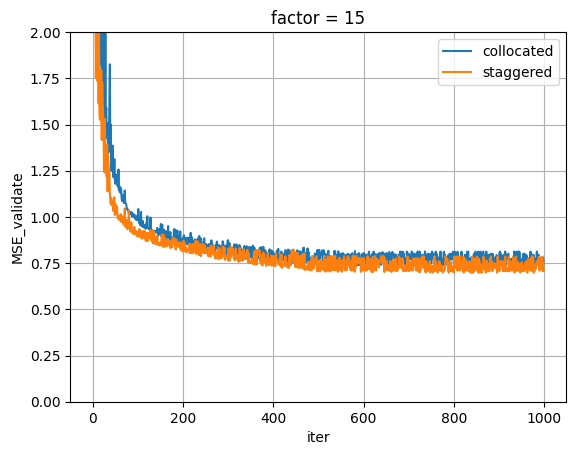

In [30]:
logger.MSE_validate.plot(label='collocated')
logger_stag.MSE_validate.plot(label='staggered')
plt.ylim([0,2])
plt.grid()
plt.legend()

In [21]:
ds = read_datasets(['test'], [4,9,12,15])

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-4
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-9
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15


In [23]:
%time skill_staggered = ds['test-9'].predict_ANN(ann_Txy_stag, ann_Txx_Tyy_stag).SGS_skill()

CPU times: user 3min 57s, sys: 2min 1s, total: 5min 59s
Wall time: 2min 8s


In [25]:
%time skill_collocated = ds['test-9'].predict_ANN(None, None, ann_Tall).SGS_skill()

CPU times: user 3min 51s, sys: 2min 8s, total: 5min 59s
Wall time: 2min 19s


Text(0.5, 1.0, 'Optimal scaling on testing dataset')

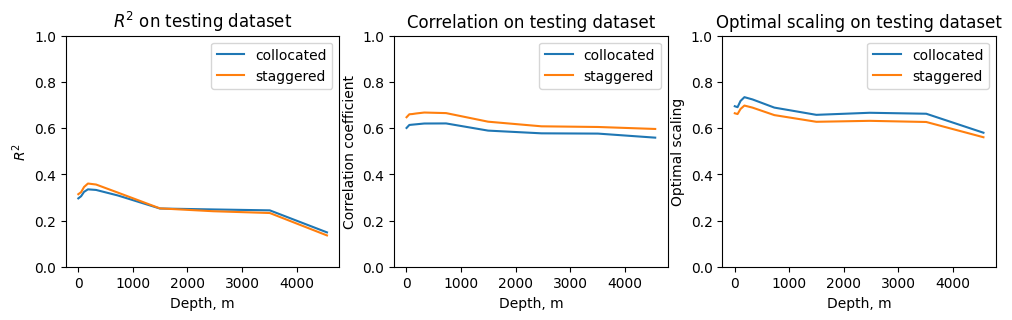

In [35]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
skill_collocated.R2.plot(label='collocated')
skill_staggered.R2.plot(label='staggered')
plt.legend()
plt.ylabel('$R^2$')
plt.xlabel('Depth, m')
plt.ylim([0,1])
plt.title('$R^2$ on testing dataset')

plt.subplot(1,3,2)
skill_collocated.corr.plot(label='collocated')
skill_staggered.corr.plot(label='staggered')
plt.legend()
plt.ylabel('Correlation coefficient')
plt.xlabel('Depth, m')
plt.ylim([0,1])
plt.title('Correlation on testing dataset')

plt.subplot(1,3,3)
skill_collocated.opt_scaling.plot(label='collocated')
skill_staggered.opt_scaling.plot(label='staggered')
plt.legend()
plt.ylabel('Optimal scaling')
plt.xlabel('Depth, m')
plt.ylim([0,1])
plt.title('Optimal scaling on testing dataset')

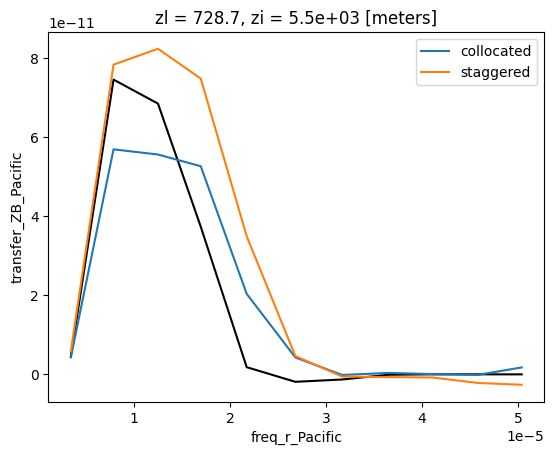

In [67]:
#skill_staggered.transfer_NA.isel(zl=0).mean('time').plot()
skill_staggered.transfer_Pacific.isel(zl=5).mean('time').plot(color='k')
skill_collocated.transfer_ZB_Pacific.isel(zl=5).mean('time').plot(label='collocated')
skill_staggered.transfer_ZB_Pacific.isel(zl=5).mean('time').plot(label='staggered')
plt.legend()

Correlation: 0.6784339089951376
Relative Error: 0.762977799198804
R2 =  0.39997602887105443
R2 max =  0.460270604200563
Optinal scaling: 0.7342485699599963
Nans [test/control]: [15938, 15938]


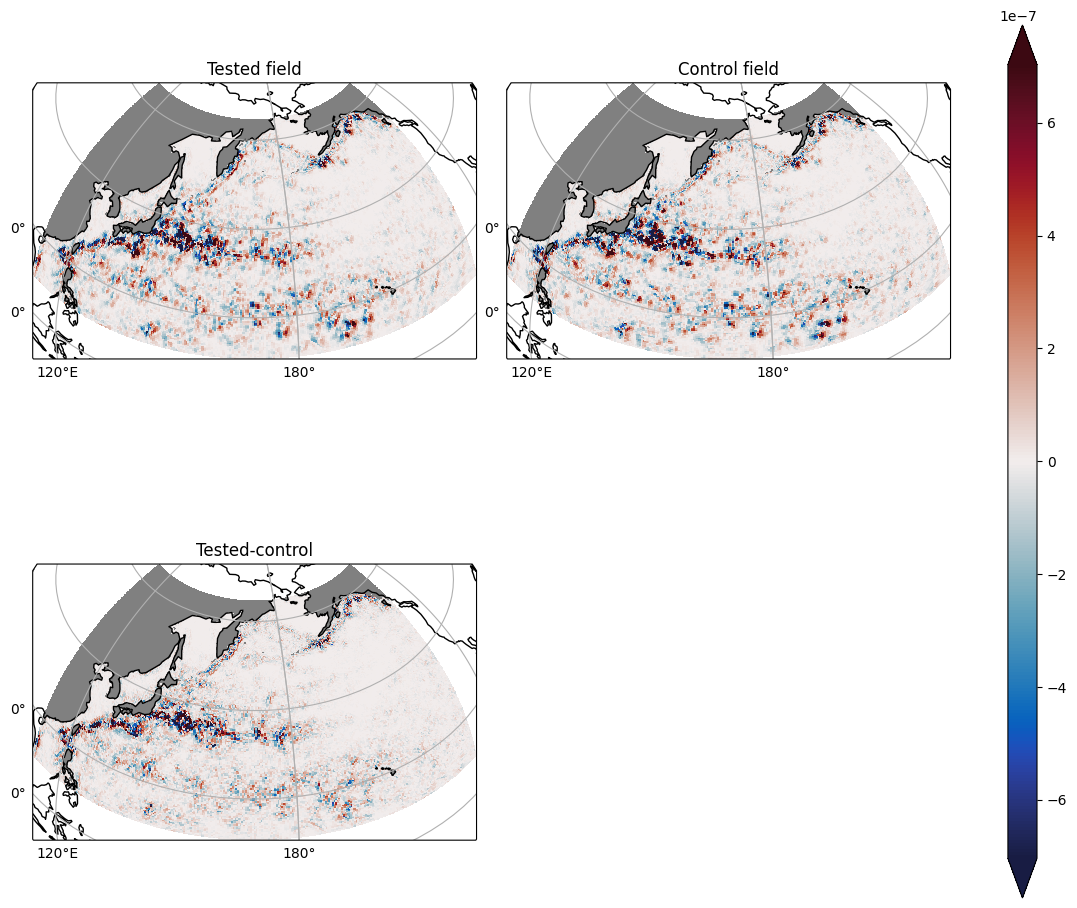

In [46]:
ds2d = ds['test-4'].select2d(zl=0, time=0)
compare(ds2d.nanvar(ds2d.state.ANN(None,None,ann_Tall)['ZB20u']),
        ds2d.nanvar(ds2d.state.ANN(ann_Txy_stag,ann_Txx_Tyy_stag)['ZB20u']), selector=select_Pacific)